In [1]:
# don't forget to install pyspark!
!pip install pyspark
import pyspark

    100% |████████████████████████████████| 188.2MB 6.2kB/s eta 0:00:01��██████████████▊   | 169.1MB 45.2MB/s eta 0:00:01███████▊  | 175.0MB 49.0MB/s eta 0:00:01��████████████▊ | 180.8MB 30.5MB/s eta 0:00:01�█▍| 184.6MB 41.5MB/s eta 0:00:01�███████████████████| 188.1MB 49.8MB/s eta 0:00:01
    100% |████████████████████████████████| 194kB 5.1MB/s eta 0:00:01
  Running setup.py bdist_wheel for pyspark ... done
  Stored in directory: /Users/nilmeier@us.ibm.com/Library/Caches/pip/wheels/15/13/d2/79b478cd48d20956d136216574cbc38e35b4957d918127c26f
Successfully built pyspark


In [33]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.linear_model import LinearRegression
from sklearn.metrics import r2_score
from sklearn.cross_validation import train_test_split
from pyspark.mllib.regression import LabeledPoint, LinearRegressionWithSGD
from pyspark.mllib.evaluation import RegressionMetrics
from pyspark.mllib.linalg import DenseVector
from pyspark.mllib.feature import StandardScaler
from pyspark.mllib.feature import StandardScalerModel
%matplotlib inline

# Solving a simple linear regression

## Numpy Analytical Solution

In [34]:
# read data into pandas dataframe from csv
df = pd.read_csv('cars.csv')

In [35]:
df.head()

,mpg,cylinders,displacement,horsepower,weight,acceleration,model,origin,car_name
0,18.0,8,307.0,130.0,3504.0,12.0,70,1,chevrolet chevelle malibu
1,15.0,8,350.0,165.0,3693.0,11.5,70,1,buick skylark 320
2,18.0,8,318.0,150.0,3436.0,11.0,70,1,plymouth satellite
3,16.0,8,304.0,150.0,3433.0,12.0,70,1,amc rebel sst
4,17.0,8,302.0,140.0,3449.0,10.5,70,1,ford torino


In [36]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 398 entries, 0 to 397
Data columns (total 9 columns):
mpg             398 non-null float64
cylinders       398 non-null int64
displacement    398 non-null float64
horsepower      398 non-null object
weight          398 non-null float64
acceleration    398 non-null float64
model           398 non-null int64
origin          398 non-null int64
car_name        398 non-null object
dtypes: float64(4), int64(3), object(2)
memory usage: 28.1+ KB


In [37]:
# remove missing values and convert to float
df['horsepower'] = df.horsepower.map(lambda x: float(x) if x != '?' else -1)
df = df[df.horsepower > -1]

Text(0,0.5,u'MPG')

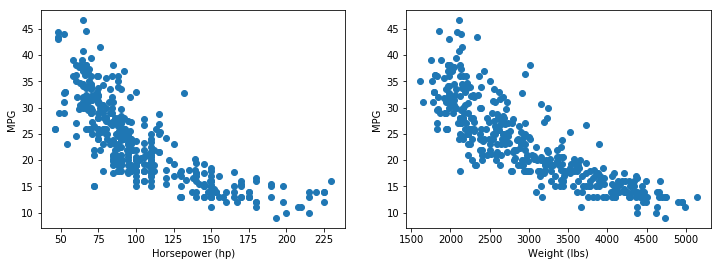

In [38]:
# visualize the data
fig, axs = plt.subplots(1, 2, figsize=(12, 4))
axs[0].scatter(df.horsepower, df.mpg)
axs[0].set_xlabel('Horsepower (hp)')
axs[0].set_ylabel('MPG')
axs[1].scatter(df.weight, df.mpg)
axs[1].set_xlabel('Weight (lbs)')
axs[1].set_ylabel('MPG')

Find the linear least squares solution to the problem:

$$y=X\beta + \epsilon$$

Where $X$ is a matrix of features, with each column corresponding to a certain feature (like horsepower)

In [39]:
# use only the horsepower and weight columns as features
def add_const(X):
    return np.concatenate((np.ones(shape=(X.shape[0],1)),X),axis=1)
X = df[['horsepower', 'weight']]
# add a column of ones so that there can be an intercept term
X = add_const(X)
y = df.mpg.values
print X

[[  1.00000000e+00   1.30000000e+02   3.50400000e+03]
 [  1.00000000e+00   1.65000000e+02   3.69300000e+03]
 [  1.00000000e+00   1.50000000e+02   3.43600000e+03]
 ..., 
 [  1.00000000e+00   8.40000000e+01   2.29500000e+03]
 [  1.00000000e+00   7.90000000e+01   2.62500000e+03]
 [  1.00000000e+00   8.20000000e+01   2.72000000e+03]]


The least squares solution is:

$$\hat{\beta} = (X^TX)^{-1}X^Ty\\
\hat{y}=X\hat{\beta}$$

In [40]:
# compute solution from explicit matrix operations
beta_hat = np.dot(np.dot(np.linalg.inv(np.dot(X.T, X)), X.T), y)
print beta_hat
# using numpy pseudo-inverse function
beta_hat = np.dot(np.linalg.pinv(X), y)
print beta_hat
# using numpy matrix objects
X_mat = np.mat(X)
y_mat = np.mat(y).T
beta_hat = (X_mat.T*X_mat).I*X_mat.T*y_mat # much more concise
print (np.array(beta_hat).ravel())

[  4.56402108e+01  -4.73028631e-02  -5.79415736e-03]
[  4.56402108e+01  -4.73028631e-02  -5.79415736e-03]
[  4.56402108e+01  -4.73028631e-02  -5.79415736e-03]


In [41]:
# compute the best fit line and find r-squared
yhat_numpy = np.dot(X, beta_hat)
print "R-squared = %1.5f" % r2_score(y, yhat_numpy)

R-squared = 0.70638


## Scikit-Learn Solution

In [42]:
# fit a LinearRegression classifier and get r-squared
clf = LinearRegression()
clf.fit(X, y)
print "R-squared = %1.5f" % clf.score(X, y)

R-squared = 0.70638


## R Solution

### Using Built-in Solver

In [43]:
%load_ext rmagic

The rmagic extension is already loaded. To reload it, use:
  %reload_ext rmagic


In [44]:
%R -i X X;  # passing X from python into R 
%R -i y y;

ERROR:root:Line magic function `%R` not found.
ERROR:root:Line magic function `%R` not found.


In [45]:
%R output=summary(lm( formula = y~X ))
print '=='
%R print(output$coefficients)
%R beta_R = output$coefficients
%R rsq_R  = output$r.squared

%R -o beta_R 
%R -o rsq_R 

print rsq_R[0]
print beta_R[:,0]
print beta_hat.T

ERROR:root:Line magic function `%R` not found.
ERROR:root:Line magic function `%R` not found.
ERROR:root:Line magic function `%R` not found.
ERROR:root:Line magic function `%R` not found.
ERROR:root:Line magic function `%R` not found.
ERROR:root:Line magic function `%R` not found.


==


NameError: name 'rsq_R' is not defined

### R Solution using matrix operations

Matrix operations in SystemML closely follow the R syntax.  
Here, we recast the least squares equation in a form that the solver can use
$$(X^TX)\hat{\beta} = X^Ty$$

In [46]:
%R beta_R_mat = solve(t(X)%*%X,t(X)%*%y)
%R -o beta_R_mat
print beta_R_mat.T

rsq_R_mat=r2_score(y, np.dot(X, beta_hat) )
print rsq_R_mat

ERROR:root:Line magic function `%R` not found.
ERROR:root:Line magic function `%R` not found.


NameError: name 'beta_R_mat' is not defined

## Spark MLlib Solution

In [47]:
#depending on your ipython config..you may need to create a spark context
from pyspark import SparkContext, SparkConf
conf = SparkConf()#.setAppName('-').setMaster(master)
sc = SparkContext(conf=conf)

ValueError: Cannot run multiple SparkContexts at once; existing SparkContext(app=pyspark-shell, master=local[*]) created by __init__ at <ipython-input-16-40411d04659a>:4 

In [54]:
# read data into Spark RDD
def parse_point(line):
    vals = line.split(',')
    return DenseVector(vals)
data = sc.textFile('cars2.csv').map(lambda x: parse_point(x))

In [55]:
parsedData = data.map(lambda x: LabeledPoint(x[0], DenseVector(x[1:])))

In [56]:
# train a MLlib LinearRegression using stochastic gradient descent as the solver
spark_model = LinearRegressionWithSGD.train(parsedData)

In [57]:
# put results into correct form for metrics object
valuesAndPreds = parsedData.map(lambda p: (float(spark_model.predict(p.features)), p.label))

In [58]:
metrics = RegressionMetrics(valuesAndPreds)
print "R-squared = %1.3f" % metrics.r2

R-squared = nan


Uh-oh, what happened? It turns out that the Spark MLlib optimization algorithm (stochastic gradient descent) does not have great convergence properties. The optimization does not converge and so we get an incorrect solution.

### Scaled input data

One work around is to scale the input data before the optimization is performed. In this case, scaling the input data means subtracting the mean of each column from the values in that column, and then dividing each value by the standard deviation of the column. In mathematical form:

$$X_{scaled}=\frac{X-\bar{X}}{\sigma}$$

In [59]:
# scale the data to zero mean and unit variance
scaler = StandardScaler(True, True)
scaler_model = scaler.fit(data) # computes and stores the mean and variance of each column
parsedData_scaled = scaler_model.transform(data) # returns scaled data

In [60]:
parsedData_scaled_transformed = parsedData_scaled.map(lambda x: LabeledPoint(x[0], DenseVector(x[1:])))

In [61]:
spark_model_scaled = LinearRegressionWithSGD.train(parsedData_scaled_transformed)

In [62]:
# put results into correct form for metrics object
valuesAndPreds = parsedData_scaled_transformed.map(lambda p: (float(spark_model_scaled.predict(p.features)), p.label))
metrics = RegressionMetrics(valuesAndPreds)

In [63]:
print "R-squared = %1.5f" % metrics.r2

R-squared = 0.70604


## Summary

In [67]:
r_squared = {'numpy': r2_score(y, yhat_numpy), 
             'sci-kit': clf.score(X, y), 
             #'R fit': rsq_R,
             #'R solve': rsq_R_mat,
             'mllib': metrics.r2}
for method in r_squared:
    print "%s R-Squared: %1.5f" % (method, r_squared[method])

sci-kit R-Squared: 0.70638
numpy R-Squared: 0.70638
mllib R-Squared: 0.70604
